# Data Science Immersive: SQL Fu
## Solution code for guided practice & demos

In [1]:
# Imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sb
%matplotlib inline

# Config
DATA_DIR = Path('.')
np.random.seed(1)

## Rossmann Drugstore Sales Data
We will be using data made available by a German drugstore, Rossmann. This data contains the daily sales made at the drugstore as well as whether there was a sale or holiday affecting the sales data.

[Kaggle Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales)

>Rossmann operates over 3,000 drug stores in 7 European countries. Currently, 
Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Data Dictionary

| Column | Description |
| -- | -- |
| **`Id`** | an Id that represents a (Store, Date) duple within the test set |
| **`Store`** | a unique Id for each store |
| **`Sales`** | the turnover for any given day (this is what you are predicting) |
| **`Customers`** | the number of customers on a given day |
| **`Open`** | an indicator for whether the store was open: 0 = closed, 1 = open |
| **`StateHoliday`** | indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None |
| **`SchoolHoliday`** | indicates if the (Store, Date) was affected by the closure of public schools |
| **`Promo`** | indicates whether a store is running a promo on that day. |

In [2]:
data = pd.read_csv(DATA_DIR / 'rossmann.csv', low_memory=False)
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## Recap: Accessing databases from pandas
Let's recap how to create a local SQLite database.

In [3]:
# We can create a SQLite database as follows:
from pandas.io import sql
import sqlite3

# Create test_sqlite_database.db file in current directory
conn = sqlite3.connect('test_sqlite_database.db')

In [4]:
# Load `data` object into `rossmann_sales` table in our sqlite db using pd.to_sql()
# N.B. we're replacing anything that's already there
data.to_sql('rossmann_sales', con=conn, if_exists='replace', index=False)

In [5]:
# Do a basic read query
sql.read_sql("SELECT * FROM rossmann_sales LIMIT 10", con=conn)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [6]:
# Calculate total customers per store
sql.read_sql("""
    SELECT Store, SUM(Customers)
    FROM rossmann_sales
    GROUP BY Store""", con=conn)

,Store,SUM(Customers)
0,1,440523
1,2,457855
2,3,584310
3,4,1036254
4,5,418588
5,6,495483
6,7,745569
7,8,516027
8,9,451677
9,10,465661


> #### CHECK: Load the Rossmann Store metadata in `rossmann-stores.csv` and create a table into the database from it called `rossmann_stores`

In [7]:
rossmann_stores = pd.read_csv(DATA_DIR / 'rossmann-stores.csv')
rossmann_stores.to_sql('rossmann_stores', if_exists='replace', index=False, con=conn)
sql.read_sql("SELECT * FROM rossmann_stores LIMIT 3", con=conn)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## Recap: SQL Syntax

### SELECT
Every query should start with SELECT. SELECT is followed by the names of the columns in the output.

SELECT is always paired with FROM, and FROM identifies the table to retrieve data from.

    SELECT <columns>
    FROM <table>

SELECT * denotes returns all of the columns.

In [8]:
# Rossmann Stores example
sql.read_sql("""
SELECT Store, Sales
FROM rossmann_sales;
""", con=conn).head()

,Store,Sales
0,1,5263
1,2,6064
2,3,8314
3,4,13995
4,5,4822


> #### CHECK: Write a query that returns the `Store`, `Date` and `Customers`.

In [9]:
sql.read_sql(
"""
SELECT Store, Date, Customers 
FROM rossmann_sales;
""", con=conn).head()

,Store,Date,Customers
0,1,2015-07-31,555
1,2,2015-07-31,625
2,3,2015-07-31,821
3,4,2015-07-31,1498
4,5,2015-07-31,559


### WHERE
WHERE is used to filter table to a specific criteria and follows the FROM clause.

    SELECT <columns>
    FROM <table>
    WHERE <condition>

The condition is some filter applied to the rows, where rows that match the condition will be in the output.

In [10]:
# Rossmann Stores example
sql.read_sql("""
SELECT Store, Sales
FROM rossmann_sales
WHERE Store = 1;
""", con=conn).head()

,Store,Sales
0,1,5263
1,1,5020
2,1,4782
3,1,5011
4,1,6102


In [11]:
# Store & Sales for Store 1 when open
sql.read_sql("""
SELECT Store, Sales
FROM rossmann_sales
WHERE Store = 1
  AND Open = 1;
""", con=conn).head()

,Store,Sales
0,1,5263
1,1,5020
2,1,4782
3,1,5011
4,1,6102


> #### CHECK: Write a query that returns the `Store`, `Date` and `Customers` for when the stores were open and running a promotion.

In [12]:
# Store & Sales for Store 1 when open
sql.read_sql("""
SELECT Store, Date, Customers
FROM rossmann_sales
WHERE Open = 1
  AND Promo = 1;
""", con=conn).head()

,Store,Date,Customers
0,1,2015-07-31,555
1,2,2015-07-31,625
2,3,2015-07-31,821
3,4,2015-07-31,1498
4,5,2015-07-31,559


### GROUP BY
`GROUP BY` allows us to aggregate over any field in the table. We identify some key with which want to segment the rows. Then, we roll-up or compute some statistic over all of the rows that match that key.

`GROUP BY` must be paired with an aggregate function - the statistic we want to compute in the rows - in the `SELECT` statement.

`COUNT(*)` denotes counting up all of the rows. Other aggregate functions commonly available are `AVG` (average), `MAX`, `MIN`, and `SUM`.

If we want an aggregate over the entire table - without results specific to any key, we can use an aggregate function in the `SELECT` statement and ignore the `GROUP BY` clause.

In [13]:
# Rossmann Stores example
sql.read_sql("""
SELECT Store, SUM(Sales), AVG(Customers)
FROM rossmann_sales
WHERE Open = 1
GROUP BY Store;
""", con=conn).head()

,Store,SUM(Sales),AVG(Customers)
0,1,3716854,564.049936
1,2,3883858,583.998724
2,3,5408261,750.077022
3,4,7556507,1321.752551
4,5,3642818,537.340180


> #### CHECK: Write a query that returns the total sales on promotion days and non-promotion days.

In [14]:
sql.read_sql("""
SELECT
    Promo,
    Store,
    SUM(Sales)
FROM rossmann_sales
GROUP BY Promo;
""", con=conn).head()

,Promo,Store,SUM(Sales)
0,0,1115,2771974337
1,1,1115,3101206286


### ORDER BY
Results of a query can be sorted by ORDER BY.

If we want to order the states by the number of polls, we would add an ORDER BY clause at the end.

The line

    SUM(Sales) as total_sales

renames the `SUM(Sales)` column as `total_sales` so we can refer to it later in the `ORDER BY` clause.

`DESC` tells the result to be in descending order as opposed to increasing.

In [15]:
# Rossmann Stores example
sql.read_sql("""
SELECT
  Store,
  SUM(Sales) as total_sales,
  AVG(Customers)
FROM rossmann_sales
WHERE Open = 1
GROUP BY Store
ORDER BY total_sales DESC;
""", con=conn).head()

,Store,total_sales,AVG(Customers)
0,262,19516842,3402.010616
1,817,17057867,3130.573980
2,562,16927322,3105.053079
3,1114,16202585,3200.946429
4,251,14896870,2450.492940


> #### CHECK: Combine `ORDER BY` with `LIMIT 1` to find the store and date which has the most sales.

In [16]:
sql.read_sql("""
SELECT
    Store,
    Date,
    Sales
FROM rossmann_sales
ORDER BY Sales DESC
LIMIT 1;
""", con=conn).head()

,Store,Date,Sales
0,909,2015-06-22,41551


> #### CHECK: Conversely, find the store and date with the fewest non-zero sales.

In [17]:
sql.read_sql("""
SELECT
    Store,
    Date,
    Sales
FROM rossmann_sales
WHERE Sales > 0
ORDER BY Sales ASC
LIMIT 1;
""", con=conn).head()

,Store,Date,Sales
0,652,2014-11-22,46


### JOIN
`JOIN` allows us to access data across many tables. We will need to specify how a row in one table links to a row in another.

Here `ON` denotes an Inner Join.

#### Inner Join
By default, most joins are an Inner Join, which means only when there is a match in both tables, does a row appear in the result.

#### Outer Join
If we want to keep the rows of one table even if there is no matching counterpart we can perform an Outer Join. Outer joins can be LEFT, RIGHT, or FULL meaning keep all the left rows, all the right rows or all the rows, respectively.

In [18]:
# Rossmann Stores example
sql.read_sql("""
SELECT
    sales.Store,
    sales.Sales,
    stores.CompetitionDistance
FROM rossmann_sales AS sales
INNER JOIN rossmann_stores AS stores ON sales.Store = stores.Store
""", con=conn).head()

,Store,Sales,CompetitionDistance
0,1,5263,1270.0
1,2,6064,570.0
2,3,8314,14130.0
3,4,13995,620.0
4,5,4822,29910.0


> #### CHECK: Combine `GROUP BY` and `JOIN` to find the average sales by `StoreType`
> - Bonus: use `AS` to clean up the column names in the result

In [19]:
sql.read_sql("""
SELECT
    stores.StoreType,
    AVG(sales.Sales) AS mean_sales
FROM rossmann_sales AS sales
LEFT JOIN rossmann_stores AS stores ON sales.Store = stores.Store
GROUP BY StoreType
""", con=conn)

,StoreType,mean_sales
0,a,5738.179710
1,b,10058.837334
2,c,5723.629246
3,d,5641.819243


> #### CHECK: How does this last query change if you exclude days when stores are not `Open`?

In [20]:
sql.read_sql("""
SELECT
    stores.StoreType,
    AVG(sales.Sales) AS mean_sales
FROM rossmann_sales AS sales
LEFT JOIN rossmann_stores AS stores ON sales.Store = stores.Store
WHERE sales.Open = 1
GROUP BY StoreType
""", con=conn)

,StoreType,mean_sales
0,a,6925.167661
1,b,10231.407505
2,c,6932.512755
3,d,6822.141881


### HAVING
`HAVING` allows you to apply a filter _after_ you've applied an aggregation with `GROUP BY`.

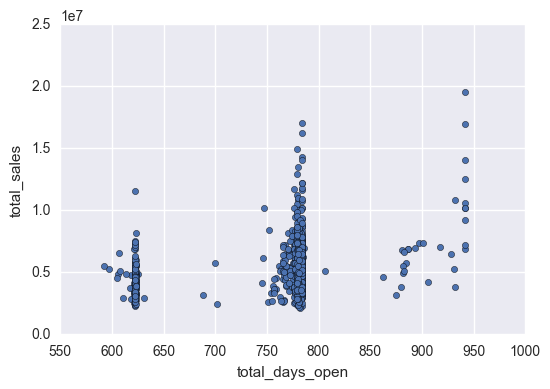

In [21]:
# HAVING example: let's find the top store in the bottom sales bracket

# First, let's look at how the total days a store is open relates to total sales from that store
sql.read_sql("""
SELECT
    Store,
    SUM(Open) AS total_days_open,
    SUM(Sales) AS total_sales
FROM rossmann_sales
GROUP BY Store
""", con=conn).plot(x='total_days_open', y='total_sales', kind='scatter')

In [22]:
# There are three distinct brackets of stores, possibly the bottom bracket have been opened most recently.
# Let's find the store with the most sales in that bracket (i.e. that has < 650 days open)
sql.read_sql("""
SELECT
    Store,
    SUM(Open) AS total_days_open,
    SUM(Sales) AS total_sales
FROM rossmann_sales
GROUP BY Store
HAVING total_days_open < 650
ORDER BY total_sales DESC
LIMIT 2
""", con=conn)

,Store,total_days_open,total_sales
0,842,622,11553523
1,1027,623,8163847


> #### CHECK: There are two distinct store types in terms of the number of Promo days. From the stores in the upper band (for total Promo days), identify the store with the least sales.

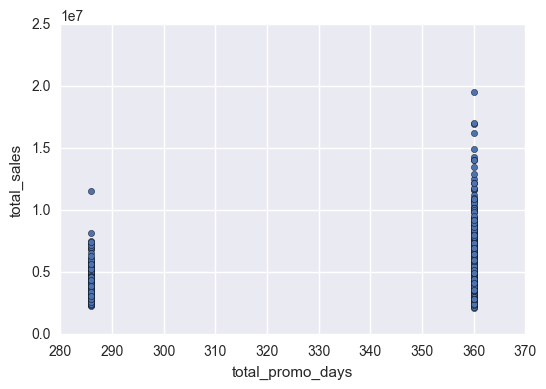

In [23]:
sql.read_sql("""
SELECT
    Store,
    SUM(Promo) AS total_promo_days,
    SUM(Sales) AS total_sales
FROM rossmann_sales
GROUP BY Store
""", con=conn).plot(x='total_promo_days', y='total_sales', kind='scatter')

In [24]:
sql.read_sql("""
SELECT
    Store,
    SUM(Promo) AS total_promo_days,
    SUM(Sales) AS total_sales
FROM rossmann_sales
GROUP BY Store
HAVING total_promo_days > 340
ORDER BY total_sales ASC
LIMIT 1
""", con=conn)

,Store,total_promo_days,total_sales
0,307,360,2114322


### CONCAT
`CONCAT` allows you to join multiple columns into one new column. In:
- SQLite and PostgreSQL, we use `column_1 || column_2`
- MySQL, we use `CONCAT(column_1, column_2)`

In [25]:
# CONCAT example: this could be useful if you need to construct a unique identifier to join between two tables
# that both have stores and dates.
sql.read_sql("""
SELECT
    Store || "_" || Date AS store_date,
    SUM(Sales) AS total_sales
FROM rossmann_sales
GROUP BY store_date
ORDER BY total_sales DESC
""", con=conn).head()

,store_date,total_sales
0,909_2015-06-22,41551
1,262_2015-04-03,38722
2,262_2015-05-01,38484
3,262_2015-05-14,38367
4,57_2014-06-16,38037


### Subquerying
Subqueries allow you to create sub-tables of results to use in your overall SQL query.

In [26]:
# Subquery example: let's say we want to find the value of each store's second highest sales.
# Let's build this up before we do the subquery...
sql.read_sql("""
SELECT
    Store,
    Date,
    MAX(Sales) AS max_sales
FROM rossmann_sales
GROUP BY Store
""", con=conn).head()

,Store,Date,max_sales
0,1,2013-12-23,9528
1,2,2014-06-30,10682
2,3,2014-06-30,15689
3,4,2013-12-30,17412
4,5,2013-12-16,11692


In [27]:
# What if SQL doesn't return the correct associated date for the maximum sales (not necessarily a given)
# We could do this if we needed to:
#   - subquery gives value of max sales for each store
#   - the INNER JOIN here acts as a filter, returning only the columns associated with the date where sales is max
sql.read_sql("""
SELECT
    sales.Store,
    sales.Date,
    sales.Sales AS max_sales
FROM rossmann_sales AS sales
INNER JOIN (
    -- Max sales per store
    SELECT
        Store,
        MAX(Sales) AS max_sales
    FROM rossmann_sales
    GROUP BY Store
    ) AS subquery ON sales.Store = subquery.Store
                 AND sales.Sales = subquery.max_sales
ORDER BY sales.Store
""", con=conn).head()

,Store,Date,max_sales
0,1,2013-12-23,9528
1,2,2014-06-30,10682
2,3,2014-06-30,15689
3,4,2013-12-30,17412
4,5,2013-12-16,11692


In [28]:
# We want each store's SECOND highest sales day though
sql.read_sql("""
SELECT
    sales.Store,
    sales.Date,
    MAX(sales.Sales) AS second_highest_sales
FROM rossmann_sales AS sales
INNER JOIN (
    -- Filter OUT max sales per store
    SELECT
        Store,
        Date,
        MAX(Sales) AS max_sales
    FROM rossmann_sales
    GROUP BY Store
    ) AS subquery ON sales.Store = subquery.Store
                 AND sales.Sales != subquery.max_sales
GROUP BY sales.Store
""", con=conn).head()

,Store,Date,second_highest_sales
0,1,2014-12-22,9331
1,2,2013-12-16,10479
2,3,2013-12-16,14647
3,4,2015-04-02,17311
4,5,2013-12-23,10877


In [29]:
# The above works, but the below demonstrates two nice concepts: CONCAT and NOT IN
# Instead of using the subquery's JOIN to filter out maximum sales days, we'll use a second subquery
# to derive a list of unique store-date identifiers to filter out
sql.read_sql("""
SELECT
    sales.Store,
    sales.Date,
    MAX(sales.Sales) AS second_highest_sales
FROM rossmann_sales AS sales
WHERE sales.Store || sales.Date NOT IN (
    SELECT store_date
    FROM (
        -- Max sales per store
        SELECT
            Store,
            Store || Date AS store_date,
            MAX(Sales) AS max_sales
        FROM rossmann_sales S
        GROUP BY Store
        )
    )
GROUP BY sales.Store
""", con=conn).head()

,Store,Date,second_highest_sales
0,1,2014-12-22,9331
1,2,2013-12-16,10479
2,3,2013-12-16,14647
3,4,2015-04-02,17311
4,5,2013-12-23,10877


## Independent Practice: Pandas and SQL
#### Exercises
1. Load the Walmart sales data (`walmart.csv`) and features data (`walmart_features.csv`)
2. Create a table for each of those datasets
3. Select the store, date and fuel price on days it was over 90 degrees
4. Select the store, date and weekly sales and temperature
5. What were average sales on holiday vs. non-holiday sales
6. What were average sales on holiday vs. non-holiday sales when the temperature was below 32 degrees

#### Bonus: What is the average store sales across each store's second hottest day?

#### Walmart Recruiting - Store Sales Forecasting

Retrieved from [Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data):

> You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

> In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

> #### 1. Load the Walmart sales data (`walmart.csv`) and features data (`walmart_features.csv`)

In [30]:
# Load the Walmart sales and store features data
walmart_sales = pd.read_csv(DATA_DIR / 'walmart.csv')
walmart_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [31]:
walmart_features = pd.read_csv(DATA_DIR / 'walmart_features.csv')
walmart_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


> #### 2. Create a table for each of those datasets

In [32]:
# Create a table for each of those datasets
walmart_sales.to_sql('walmart_sales', index=False, if_exists='replace', con = conn)
walmart_features.to_sql('walmart_features', if_exists='replace', index=False, con=conn)

> #### 3. Select the store, date and fuel price on days it was over 90 degrees

In [33]:
# Select the store, date and fuel price on days it was over 90 degrees
query = """
SELECT
  Date,
  Store,
  Fuel_Price,
  Temperature
FROM walmart_features
WHERE Temperature > 90
"""
sql.read_sql(query, con = conn).head()

,Date,Store,Fuel_Price,Temperature
0,2011-08-05,1,3.684,91.65
1,2011-08-12,1,3.638,90.76
2,2011-07-29,2,3.682,90.07
3,2011-08-05,2,3.684,93.34
4,2011-08-12,2,3.638,91.58


> #### 4. Select the store, date and weekly sales and temperature

In [34]:
# Select the store, date and weekly sales and temperature
query = """
SELECT 
  sales.Store,
  sales.Date,
  sales.Weekly_Sales,
  features.Temperature
FROM walmart_sales as sales
JOIN walmart_features as features ON sales.Store = features.Store
                                 AND sales.Date = features.Date
"""
sql.read_sql(query, con = conn).head()

,Store,Date,Weekly_Sales,Temperature
0,1,2010-02-05,24924.50,42.31
1,1,2010-02-12,46039.49,38.51
2,1,2010-02-19,41595.55,39.93
3,1,2010-02-26,19403.54,46.63
4,1,2010-03-05,21827.90,46.50


> #### 5. What were average sales on holiday vs. non-holiday sales

In [35]:
# What were average sales on holiday vs. non-holiday sales
query = """
SELECT 
  IsHoliday,
  AVG(Weekly_Sales)
FROM walmart_sales AS sales
GROUP BY IsHoliday
"""
sql.read_sql(query, con = conn)

,IsHoliday,AVG(Weekly_Sales)
0,0,15901.445069
1,1,17035.823187


> #### 6. What were average sales on holiday vs. non-holiday sales when the temperature was below 32 degrees

In [36]:
# What were average sales on holiday vs. non-holiday sales when the temperature was below 32 degrees
query = """
SELECT 
  sales.IsHoliday,
  AVG(sales.Weekly_Sales)
FROM walmart_sales AS sales
JOIN walmart_features AS features ON sales.Store = features.Store
                                 AND sales.Date = features.Date
WHERE features.Temperature < 32
GROUP BY sales.IsHoliday
"""
sql.read_sql(query, con = conn)

,IsHoliday,AVG(sales.Weekly_Sales)
0,0,15275.770307
1,1,15111.471238


> #### Bonus: What is the average store sales across each store's second hottest day?

This fiendish problem from Rich is possible using a single query and some subqueries, but it's very complex! Instead, I'm going to use some temporary tables and build up the query step-by-step to demonstrate how all the parts fit together. Creating temporary tables is almost identical to creating permanent tables, except they're only visible to you and will be deleted when you close your db connection (e.g. in this case, the connection closes when you close the notebook or restart the kernel). Also, pandas only has methods for turning SQL into dataframes and vice-versa, but not for executing an SQL statement directly, so I'm using the sqlite3 library for this.

Using temporary tables in this way is a common optimisation technique, and much simpler to debug too as you can inspect the intermediate queries to check it's doing what you expect!

**Note: This level of convolutory SQL kung fu is pretty rare in practice, and is essentially an example of SQL-based "code golf". It's great as a technical challenge, or to really test someone's SQL abilities, but don't worry if this seems incredibly complex...it is!**

In [37]:
# We'll need this cursor object to execute the SQL statements
cursor = conn.cursor()

In [38]:
# This table contains the date on which each store experienced its max temp.
# We can't see the associated dates yet, we have to join those in separately.
cursor.execute("""
CREATE TEMPORARY TABLE max_temp_per_store AS
    SELECT
        Store,
        MAX(Temperature) AS max_temp
    FROM walmart_features
    GROUP BY Store
""")
conn.commit()

In [39]:
# Checks...
#   > store 1 has max temp of 91.65
#   > store 3 has max temp of 89.12
sql.read_sql("SELECT * FROM max_temp_per_store LIMIT 5;", con = conn)

,Store,max_temp
0,1,91.65
1,2,93.34
2,3,89.12
3,4,86.29
4,5,91.07


In [40]:
# Now we can see the relevant dates by joining them in
cursor.execute("""
CREATE TEMPORARY TABLE max_temp_store_date AS
    SELECT
        F.Store,
        F.Date,
        F.Temperature AS max_temp,
        F.Store || F.Date AS store_date_uid
    FROM max_temp_per_store AS S
    LEFT JOIN walmart_features AS F ON S.Store = F.Store
                                   AND S.max_temp = F.Temperature
""")
conn.commit()

In [41]:
# Checks...
#   > store 1 has max temp of 91.65 still, on 2011-08-05
#   > store 3 has max temp of 89.12 still, on 2011-09-02
sql.read_sql("SELECT * FROM max_temp_store_date LIMIT 10;", con = conn)

,Store,Date,max_temp,store_date_uid
0,1,2011-08-05,91.65,12011-08-05
1,2,2011-08-05,93.34,22011-08-05
2,3,2011-09-02,89.12,32011-09-02
3,4,2013-06-28,86.29,42013-06-28
4,5,2011-08-05,91.07,52011-08-05
5,6,2011-08-05,91.46,62011-08-05
6,7,2012-06-29,68.84,72012-06-29
7,8,2011-07-01,87.26,82011-07-01
8,9,2011-08-12,91.63,92011-08-12
9,10,2011-07-01,95.36,102011-07-01


In [42]:
# Check...compare with simple filter to confirm this is real data
#   > store 1 has temp of 91.65 on 2011-08-05
#   > store 3 has temp of 89.12 on 2011-09-02
sql.read_sql("""
SELECT Store, Date, Temperature
FROM walmart_features
WHERE Store IN (1, 3) AND Date IN ('2011-08-05', '2011-09-02');
""", con = conn)

,Store,Date,Temperature
0,1,2011-08-05,91.65
1,1,2011-09-02,87.83
2,3,2011-08-05,88.45
3,3,2011-09-02,89.12


In [43]:
# Check...do any stores have more than one entry here? (No, phew!)
sql.read_sql("""
SELECT Store, COUNT(*) AS total
FROM max_temp_store_date
GROUP BY Store
ORDER BY total DESC
LIMIT 3;
""", con = conn)

,Store,total
0,1,1
1,2,1
2,3,1


In [44]:
# Now create a new table which has the above store/date combos filtered out using WHERE and NOT IN operators.
# When we do MAX(Temperature) this time, it's therefore selecting the days with the second highest
# temperatures for each store. As above, we need to join in the related dates in a separate step.
cursor.execute("""
CREATE TEMPORARY TABLE store_data_with_max_removed AS
    SELECT
        Store,
        MAX(Temperature) AS second_highest_temp
    FROM walmart_features
    WHERE Store || Date NOT IN (SELECT store_date_uid FROM max_temp_store_date)
    GROUP BY Store
""")
conn.commit()

In [45]:
# Checks...
#   > store 1 has 2nd highest temp of 90.76 (lower than max temp of 91.65)
#   > store 3 has 2nd highest temp of 88.88 (lower than max temp of 89.12)
sql.read_sql("SELECT * FROM store_data_with_max_removed LIMIT 5;", con = conn)

,Store,second_highest_temp
0,1,90.76
1,2,91.58
2,3,88.88
3,4,86.09
4,5,90.38


In [46]:
# As above, join in the dates. We'll use this in next step to filter on...(!)
cursor.execute("""
CREATE TEMPORARY TABLE second_highest_temps_store_date AS
    SELECT
        F.Store,
        F.Date,
        F.Temperature AS second_highest_temp,
        F.Store || F.Date AS store_date_uid
    FROM store_data_with_max_removed AS S
    LEFT JOIN walmart_features AS F ON S.Store = F.Store
                                   AND S.second_highest_temp = F.Temperature
""")
conn.commit()

In [47]:
# Checks...
#   > store 1 has 2nd highest temp of 90.76 still, on 2011-08-12
#   > store 3 has 2nd highest temp of 88.88 still, on 2011-08-12
sql.read_sql("SELECT * FROM second_highest_temps_store_date LIMIT 10;", con = conn)

,Store,Date,second_highest_temp,store_date_uid
0,1,2011-08-12,90.76,12011-08-12
1,2,2011-08-12,91.58,22011-08-12
2,3,2011-08-12,88.88,32011-08-12
3,4,2011-08-05,86.09,42011-08-05
4,5,2011-09-02,90.38,52011-09-02
5,6,2011-09-02,91.22,62011-09-02
6,7,2010-07-30,66.07,72010-07-30
7,8,2011-07-29,86.46,82011-07-29
8,9,2011-08-05,91.52,92011-08-05
9,10,2013-07-05,93.54,102013-07-05


In [48]:
# Check...compare with simple filter to confirm this is real data
#   > store 1 has temp of 90.76 on 2011-08-12
#   > store 3 has temp of 88.88 on 2011-08-12
sql.read_sql("""
SELECT Store, Date, Temperature
FROM walmart_features
WHERE Store IN (1, 3) AND Date = '2011-08-12';
""", con = conn)

,Store,Date,Temperature
0,1,2011-08-12,90.76
1,3,2011-08-12,88.88


In [49]:
# FINALLY (!), we simply average across the dates & stores provided in the previous step
sql.read_sql("""
SELECT
  AVG(Weekly_Sales) AS average_sales
FROM walmart_sales
WHERE Store || Date IN (SELECT store_date_uid FROM second_highest_temps_store_date)
""", con = conn)

,average_sales
0,16334.922297


#### As one query...!
To prove it's possible. I have a sneaking suspicion we can simplify this quite a bit (filtering and joining on store/temp combos will save you several subqueries by not messing around with creating store/date combos). I'll leave that as an exercise to the reader.

In [50]:
sql.read_sql("""
-- Avg sales over the selected dates for each store
SELECT
  AVG(Weekly_Sales) AS average_sales
FROM walmart_sales
WHERE Store || Date IN (
  -- List of store/date UIDs to filter on
  SELECT store_date_uid
  FROM (
    -- Date of second highest temperatures for each store
    SELECT
      F.Store,
      F.Date,
      F.Temperature AS second_highest_temp,
      F.Store || F.Date AS store_date_uid
    FROM (
      -- Second highest temperatures per store
      SELECT
        Store,
        MAX(Temperature) AS second_highest_temp
      FROM walmart_features
      WHERE Store || Date NOT IN (
        -- List of store/date UIDs to filter out
        SELECT store_date_uid
        FROM (
          -- Date of max temperature for each store
          SELECT
            F.Store,
            F.Date,
            F.Temperature AS max_temp,
            F.Store || F.Date AS store_date_uid
          FROM (
            -- Max temperature per store
            SELECT
              Store,
              MAX(Temperature) AS max_temp
            FROM walmart_features
            GROUP BY Store
          ) AS S
          LEFT JOIN walmart_features AS F ON S.Store = F.Store
                                         AND S.max_temp = F.Temperature
        )
      )
      GROUP BY Store
    ) AS S
    LEFT JOIN walmart_features AS F ON S.Store = F.Store
                                   AND S.second_highest_temp = F.Temperature
    )
)
""", con = conn)

,average_sales
0,16334.922297


In [51]:
# In production, this is a pretty important step. Locally, the only effect it has is to flush the temporary tables.
conn.close()